# Immune Control
Please run Immune-* for all modifications with and without control.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from itertools import product
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile


In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts


In [3]:
PATH = os.path.expanduser('~/data/2023_Immune')
PATH_NO_CONTROL = os.path.expanduser('~/data/2023_Immune_no_control')

IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']

! mkdir -p {PATH}/pics

In [4]:
ts = []
for m in MODIFICATIONS:
    t_control = pd.read_csv(PATH + f'/{m}_full_bench_df.csv.gz', compression='gzip')
    t_control['modification'] = m
    t_control['control'] = True
    t_control.sort_values(by=['modification', 'cell', 'name'], inplace=True)
    t_no_control = pd.read_csv(PATH_NO_CONTROL + f'/{m}_full_bench_df.csv.gz', compression='gzip')
    t_no_control['modification'] = m
    t_no_control['control'] = False
    t_no_control.sort_values(by=['modification', 'cell', 'name'], inplace=True)
    t_control['ratio'] = 1.0
    t_no_control['ratio'] = [d(pnc, pc) for pnc, pc in zip(t_no_control['peaks'], t_control['peaks'])]
    ts.append(t_control)
    ts.append(t_no_control)
    del t_control
    del t_no_control

full_bench_df_all = pd.concat(ts).reset_index(drop=True)
del ts
full_bench_df_all.sample(5)

,cell,name,peaks,peaks_len,tss,tss_len,peaks_overlap,peaks_overlap_len,tss_overlap,tss_overlap_len,...,sensitivity_len,f1_len,jaccard,modification,control,ratio,dnase,dnase_len,dnase_overlap,dnase_overlap_len
220,Monocyte,SPAN - MACS2 broad,13761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,H3K36me3,True,1.000000,NaN,NaN,NaN,NaN
212,Monocyte,MACS2,127115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,H3K36me3,True,1.000000,NaN,NaN,NaN,NaN
57,TCell,SPAN - MACS2,2880,1857471.0,18413.0,19197767.0,202.0,67988.0,205.0,67988.0,...,0.003541,0.006458,0.003239,H3K4me3,False,1.364282,NaN,NaN,NaN,NaN
196,Monocyte,SPAN,48784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,H3K27me3,False,1.034809,NaN,NaN,NaN,NaN
146,Monocyte,SPAN,114107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,H3K4me1,False,1.002301,NaN,NaN,NaN,NaN


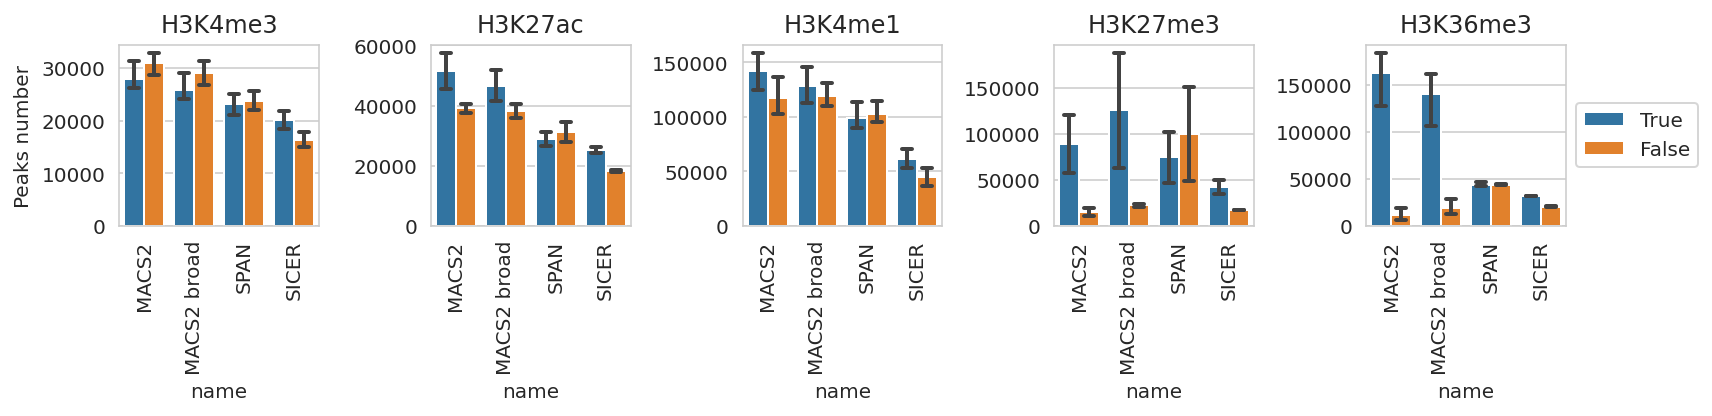

In [5]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=full_bench_df_all[full_bench_df_all['modification'] == m],
                            x='name', y='peaks', hue='control',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   # 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   # 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ],
                            hue_order=[True, False]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
    ax.set_title(m)
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(f'{PATH}/pics/full_bench_df_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

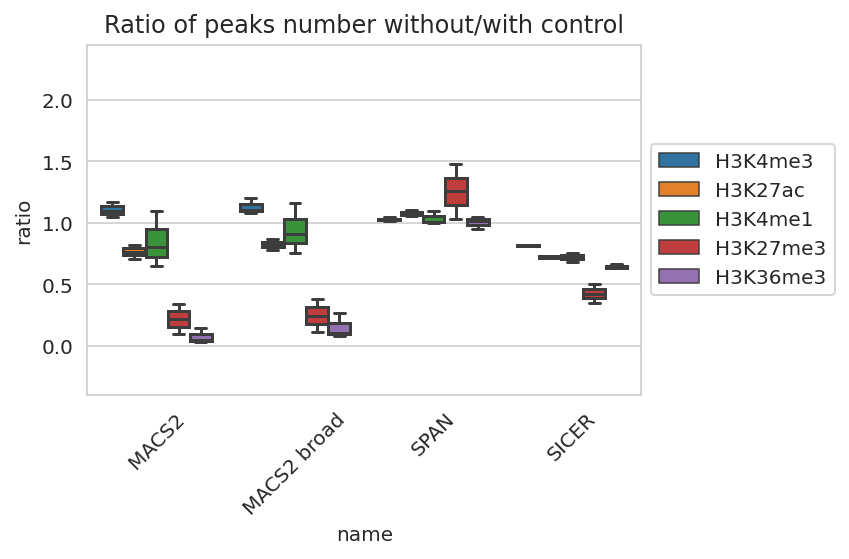

In [6]:
t = full_bench_df_all[full_bench_df_all['name'].isin(set(['MACS2', 'MACS2 broad', 'SPAN', 'SICER']))]
plt.figure(figsize=(6, 4))
g_results = sns.boxplot(data=t[t['control'] == False],
                        x='name', y='ratio', hue='modification',
                        # capsize=.05, errwidth=2,
                        hue_order=MODIFICATIONS,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False
                        )

ax = g_results.axes
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-0.4, 2.45)
ax.set_title('Ratio of peaks number without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/full_bench_df_all2.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Jaccard with control

In [7]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in IMMUNE_CELLS if cc in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        if fdr and cell and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, fdr, ps, avls)
    return df_fdr


def load_peaks(path):
    df_fdr_macs2 = load_peaks_fdr(os.path.join(path, 'macs2'), '.narrowPeak', ['0.05'])
    df_fdr_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_fdr_macs2))

    df_fdr_macs2broad = load_peaks_fdr(os.path.join(path, 'macs2'), '.broadPeak', ['0.1'])
    df_fdr_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_fdr_macs2broad))

    df_fdr_sicer = load_peaks_fdr(os.path.join(path, 'sicer'), 'summary-FDR', ['0.01'])
    if len(df_fdr_sicer) == 0:
        df_fdr_sicer = load_peaks_fdr(os.path.join(path, 'sicer'), '.scoreisland', ['0.01'])
    df_fdr_sicer['tool'] = 'SICER'
    print('SICER', len(df_fdr_sicer))

    df_fdr_span = load_peaks_fdr(os.path.join(path, 'span'), '.peak', ['0.05'])
    df_fdr_span['tool'] = 'SPAN'
    print('SPAN', len(df_fdr_span))

    return pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span]).reset_index(drop=True)

In [8]:
df_control_peaks = load_peaks(PATH)
df_control_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 14


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 14


  0%|          | 0/118 [00:00<?, ?it/s]

SICER 14


  0%|          | 0/17 [00:00<?, ?it/s]

SPAN 14


,file,modification,cell,fdr,peaks,avlength,tool
20,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K4me1,Monocyte,0.1,112393,1189.635876,MACS2 broad
23,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27me3,BCell,0.1,187656,617.866266,MACS2 broad
47,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K4me1,TCell,0.05,94649,1758.373770,SPAN
14,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K27ac,TCell,0.1,51740,1224.777812,MACS2 broad
4,/home/jetbrains/data/2023_Immune/macs2/BCell_H...,H3K27me3,BCell,0.05,120947,519.377033,MACS2


In [9]:
df_no_control_peaks = load_peaks(PATH_NO_CONTROL)
df_no_control_peaks.sample(5)

  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 14


  0%|          | 0/112 [00:00<?, ?it/s]

MACS2 broad 14


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

SICER 14


  0%|          | 0/15 [00:00<?, ?it/s]

SPAN 14


,file,modification,cell,fdr,peaks,avlength,tool
19,/home/jetbrains/data/2023_Immune_no_control/ma...,H3K27me3,Monocyte,0.1,24114,637.662727,MACS2 broad
32,/home/jetbrains/data/2023_Immune_no_control/si...,H3K4me3,BCell,0.01,14926,2860.061235,SICER
46,/home/jetbrains/data/2023_Immune_no_control/sp...,H3K27ac,BCell,0.05,27924,2216.850380,SPAN
37,/home/jetbrains/data/2023_Immune_no_control/si...,H3K27ac,TCell,0.01,18725,5725.333778,SICER
2,/home/jetbrains/data/2023_Immune_no_control/ma...,H3K27me3,Monocyte,0.05,19683,563.258192,MACS2


In [10]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [11]:
tf = tempfile.mktemp()
ts = []
for m, c, t in tqdm(product(MODIFICATIONS,
                               IMMUNE_CELLS,
                               TOOLS)):
    pc = df_control_peaks[(df_control_peaks['modification'] == m) &
                          (df_control_peaks['cell'] == c) &
                          (df_control_peaks['tool'] == t)]
    pnc = df_no_control_peaks[(df_no_control_peaks['modification'] == m) &
                              (df_no_control_peaks['cell'] == c) &
                              (df_no_control_peaks['tool'] == t)]
    if len(pc) != 1 or len(pnc) != 1:
        continue
    pcf = pc['file'].values[0]
    pncf = pnc['file'].values[0]
    !bedtools intersect -a {pcf} -b {pncf} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    pcf_len = bedl(pcf).sum()
    pncf_len = bedl(pncf).sum()
    jaccard = d(overlap_len, pcf_len + pncf_len - overlap_len)
    ts.append((m, c, t, jaccard))
jaccard_df = pd.DataFrame(data=ts, columns=['modification', 'cell', 'tool', 'jaccard'])
jaccard_df.sample(5)

0it [00:00, ?it/s]

,modification,cell,tool,jaccard
6,H3K4me3,TCell,SPAN,0.950218
2,H3K4me3,BCell,SPAN,0.937998
21,H3K4me1,BCell,MACS2 broad,0.497055
30,H3K4me1,Monocyte,SPAN,0.947816
47,H3K36me3,BCell,SICER,0.894527


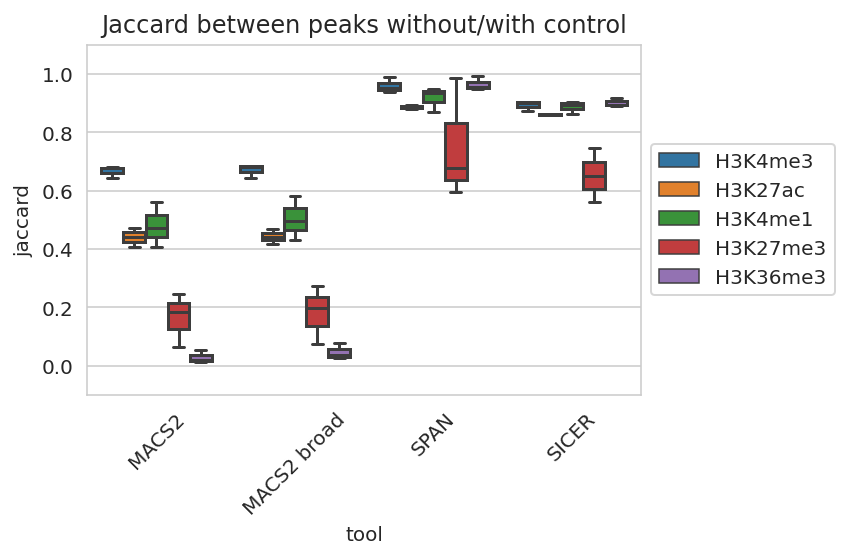

In [12]:
plt.figure(figsize=(6, 4))
g_results = sns.boxplot(data=jaccard_df,
                        x='tool', y='jaccard', hue='modification',
                        # capsize=.05, errwidth=2,
                        hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False
                        )

ax = g_results.axes
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylim(-0.1, 1.1)
ax.set_title('Jaccard between peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{PATH}/pics/full_bench_df_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()